In [69]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy import stats
from sklearn import metrics
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [70]:
GPU_TDP = 250 # Watt
CPU_TDP = 85 # Watt
time = 1.6679636111111111 # hours
GPU_utilisation =  98.41828958509737 #percentage
CPU_utilisation = 1 #assumed

In [71]:
dictionary = {'method':[],'energy':[]}

In [72]:
#mlco2 energy used = 0.4169909027777778 kWh
mlco2= (time * GPU_TDP) / 1000
dictionary['method'].append('time * GPU TDP')
dictionary['energy'].append(mlco2)

In [73]:
ai_and_compute = (time * GPU_TDP * 1/3) / 1000
dictionary['method'].append('time * GPU TDP * 1/3 util')
dictionary['energy'].append(ai_and_compute)

In [74]:
actual_util = (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation)) / 1000
dictionary['method'].append('time * (GPU + CPU) * real_util')
dictionary['energy'].append(actual_util)

In [75]:
# empirical values
# nvidia-smi GPU energy consumption = 0.43921391388888886 kWh
# GPU + CPU energy consumption = 0.5627291196798899 kWh
# power monitor reading = 0.6127022608333333 kWh
power_monitor_reading = 0.6127022608333333
dictionary['method'].append('empirical')
dictionary['energy'].append(power_monitor_reading)

In [76]:
df= pd.DataFrame(dictionary)

In [77]:
df.head()

,method,energy
0,time * GPU TDP,0.416991
1,time * GPU TDP * 1/3 util,0.138997
2,time * (GPU + CPU) * real_util,0.552172
3,empirical,0.612702


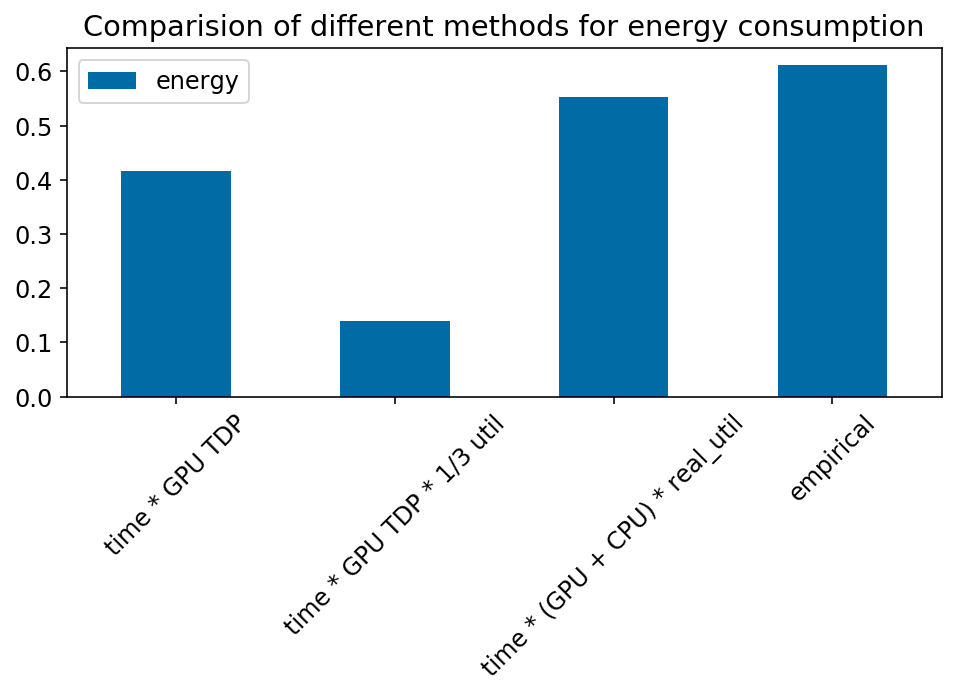

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
df.plot.bar(x='method', y='energy', rot=45,title="Comparision of different methods for energy consumption",ax=ax)
ax.set_xlabel("")
plt.tight_layout()
ax.figure.savefig("viz/compareEnergy.png",dpi=300)

## Test correlation

In [79]:
power_monitor_df = pd.read_csv("results/pretrain_power_monitor.csv")

In [80]:
power_monitor_df['last_changed'] = pd.to_datetime(power_monitor_df['last_changed'], errors='coerce')
power_monitor_df.dropna(subset=['last_changed'], inplace=True)
power_monitor_df.set_index('last_changed', inplace=True)

In [81]:
start_date = '2020-06-16'
end_date = '2020-06-16'
start_time = '21:38:59' #one hour behind
end_time = '23:18:51'
subset_df = power_monitor_df.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
total_energy_pm = ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600) #sampled every 3 sec
total_energy_pm

0.6127022608333333

In [82]:
end = '2020-06-17 00:18:51.137000'
start = '2020-06-16 22:38:59.567000'

start = datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
end = datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)   

# start_time = [start for i in range(0,95,5)] 
# end_time = [start + timedelta(hours=0, minutes=i)
#                  for i in range(5,100,5)] 

In [83]:
# try normal distribution
mu, sigma = 50, 20 # mean and standard deviation
s = np.random.normal(mu, sigma, 100)

In [84]:

end_time = [start + timedelta(hours=0, minutes=i)
                 for i in s if i >=0] 
start_time = [start for i in range(len(end_time))] 

In [85]:
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = power_monitor_df.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [86]:
df_time_interval= pd.DataFrame(start_time,columns=['start'])

In [87]:
df_time_interval['end'] = end_time
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end"]]

In [88]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'empirical'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [89]:
def model_based(time):
    return (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation) / (1000 * 3600) )

In [90]:
for index, row in df_time_interval.iterrows(): 
    time = row['end'] - row['start']
    seconds = time.total_seconds()
    df_time_interval.at[index,'model_based'] = model_based(seconds)

In [91]:
df_time_interval.tail()

,start,end,s_date,e_date,s_time,e_time,empirical,model_based
95,2020-06-16 21:38:59.567,2020-06-16 22:05:12.427156,2020-06-16,2020-06-16,21:38:59,22:05:12,0.158634,0.144636
96,2020-06-16 21:38:59.567,2020-06-16 22:36:14.913827,2020-06-16,2020-06-16,21:38:59,22:36:14,0.348796,0.315905
97,2020-06-16 21:38:59.567,2020-06-16 22:10:26.142016,2020-06-16,2020-06-16,21:38:59,22:10:26,0.189919,0.173484
98,2020-06-16 21:38:59.567,2020-06-16 22:21:26.256378,2020-06-16,2020-06-16,21:38:59,22:21:26,0.257335,0.234186
99,2020-06-16 21:38:59.567,2020-06-16 22:29:27.635829,2020-06-16,2020-06-16,21:38:59,22:29:27,0.307071,0.278453


coeff: 0.9998026647082742
r2: 0.9996053683577657


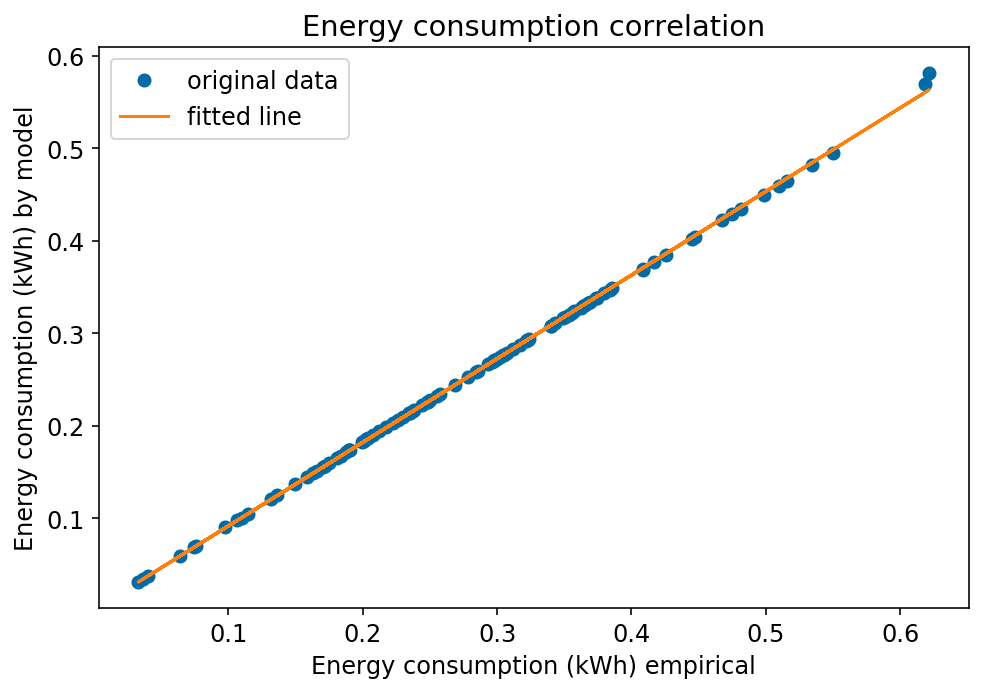

In [92]:
x = df_time_interval['empirical']
y = df_time_interval['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/pretrain_model_vs_empirical.png',dpi=300)

In [93]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.02885430578896423 
 mae: 0.026127991043865987


## See how the values scale with time using finetuning training 

In [94]:
df_finetune = pd.read_csv("results/model_pm_energy_finetune.csv")

In [95]:
df_finetune['power'].count()

51

In [96]:
df_finetune['time * GPU TDP'] = df_finetune['time_in_hour'] * GPU_TDP / 1000
df_finetune['time * GPU TDP * 1/3 util'] = (df_finetune['time_in_hour'] * GPU_TDP * 1/3) / 1000
df_finetune['time * (GPU + CPU) * real_util'] = ((df_finetune['time_in_hour'] *  GPU_TDP * GPU_utilisation/100 )
  +  (df_finetune['cpu_time']/3600 * CPU_TDP * CPU_utilisation)) / 1000

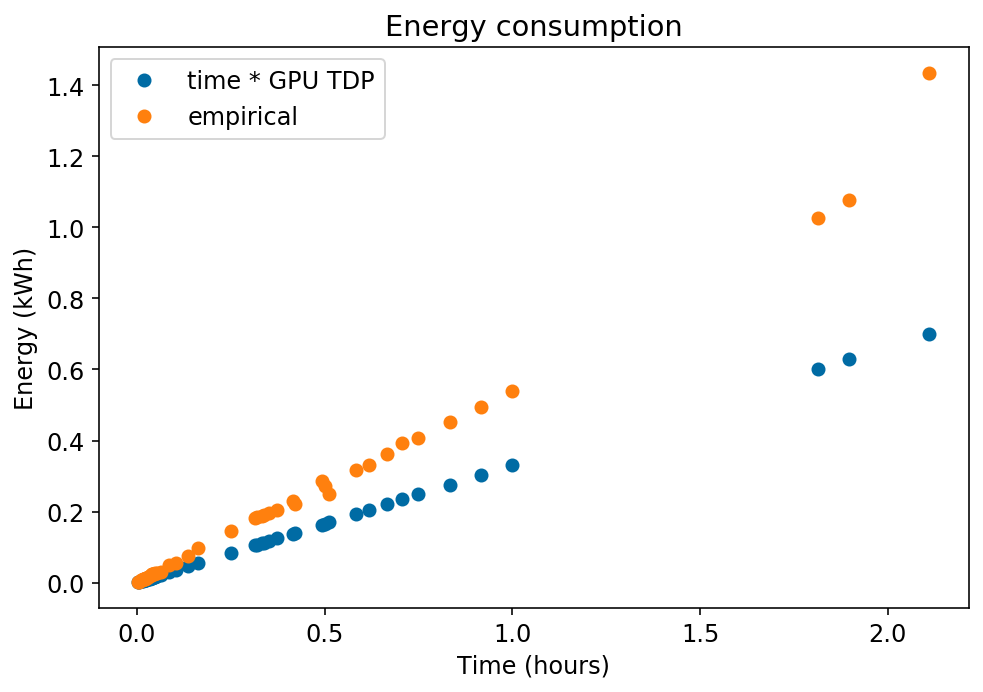

In [97]:
x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
plt.plot(x, y1,'o', label="time * GPU TDP")
plt.plot(x, y2,'o', label="empirical")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/mlco2ModelVsPMPower.png',dpi=300)

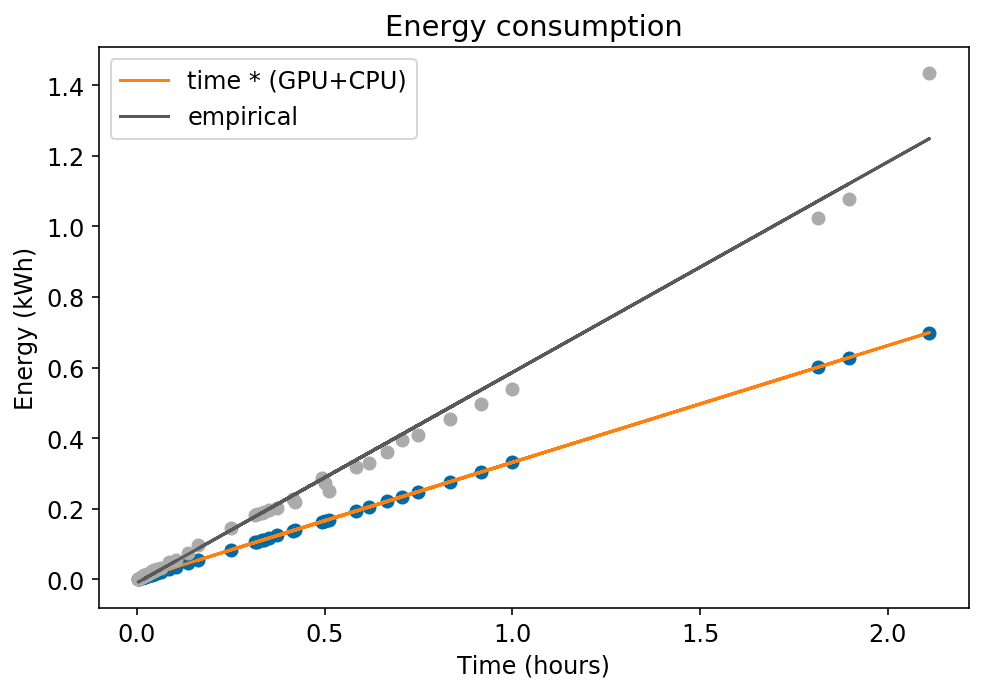

In [98]:

x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
plt.plot(x, y1,'o')
plt.plot(x, slope * x + intercept, label='time * (GPU+CPU)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
plt.plot(x, y2,'o')
plt.plot(x, slope * x + intercept, label='empirical')
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/CPU_GPU_ModelVsPMPower.png',dpi=300)

In [99]:
stat, p = stats.normaltest(x)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=35.934, p=0.000
Sample does not look Gaussian (reject H0)


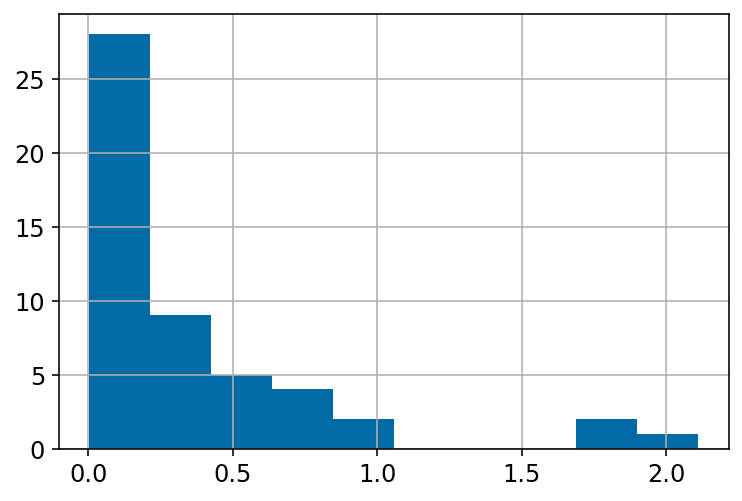

In [100]:
x.hist()

In [101]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')

coeff: 0.9939498548250272
r2: 0.9879363139066926


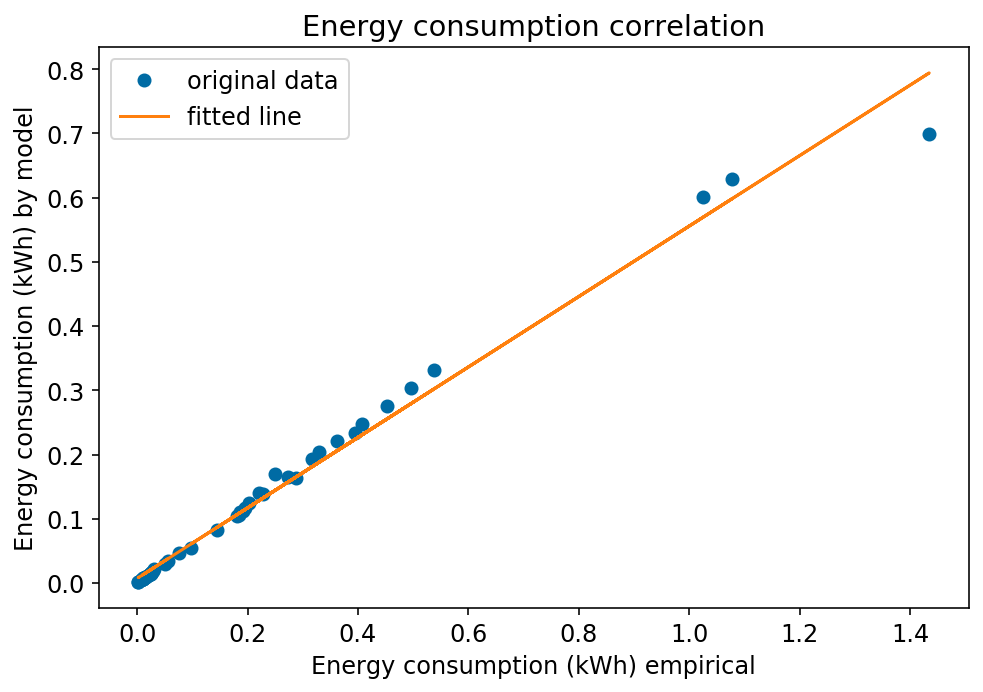

In [102]:
x = df_finetune['pm_energy_consumption']
y = df_finetune['time * (GPU + CPU) * real_util']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption (kWh) by model")
plt.xlabel("Energy consumption (kWh) empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

In [103]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.15525863897786293 
 mae: 0.08172864013759067


coeff: 0.9992700336649486
r2: 0.9985406001807475


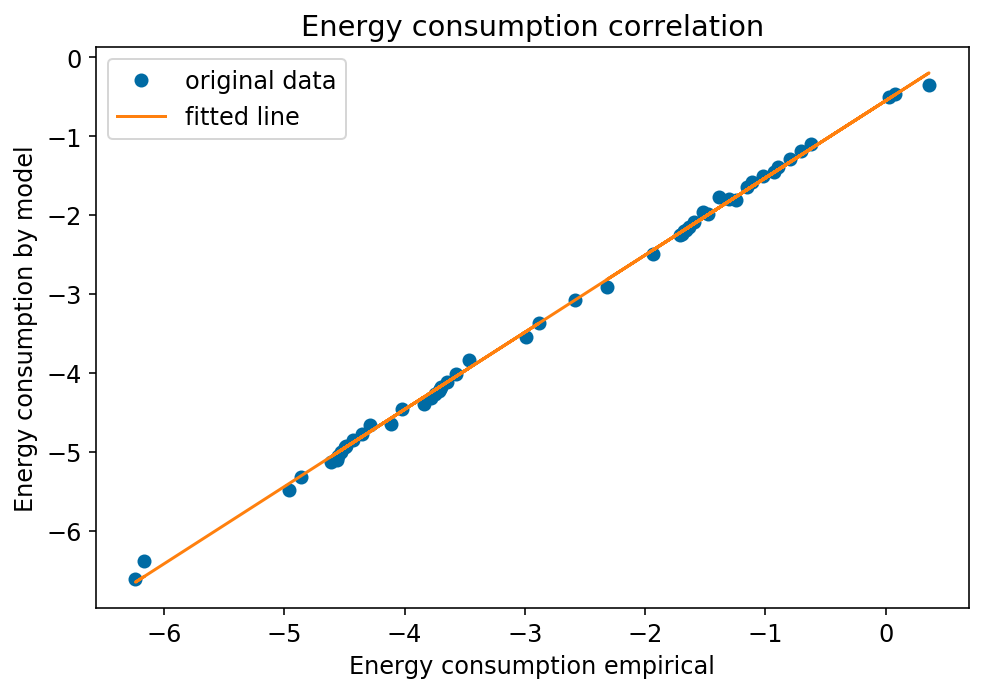

In [105]:
## try log

x = np.log(df_finetune['pm_energy_consumption'])
y = np.log(df_finetune['time * (GPU + CPU) * real_util'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption by model")
plt.xlabel("Energy consumption empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

## merge data 

In [64]:
df_finetune.rename(columns={'pm_energy_consumption':'empirical','time * (GPU + CPU) * real_util':'model_based'},
                   inplace=True)

In [65]:
merge_df = df_finetune.append(df_time_interval)

coeff: 0.9341065086557008
r2: 0.8725549695129428


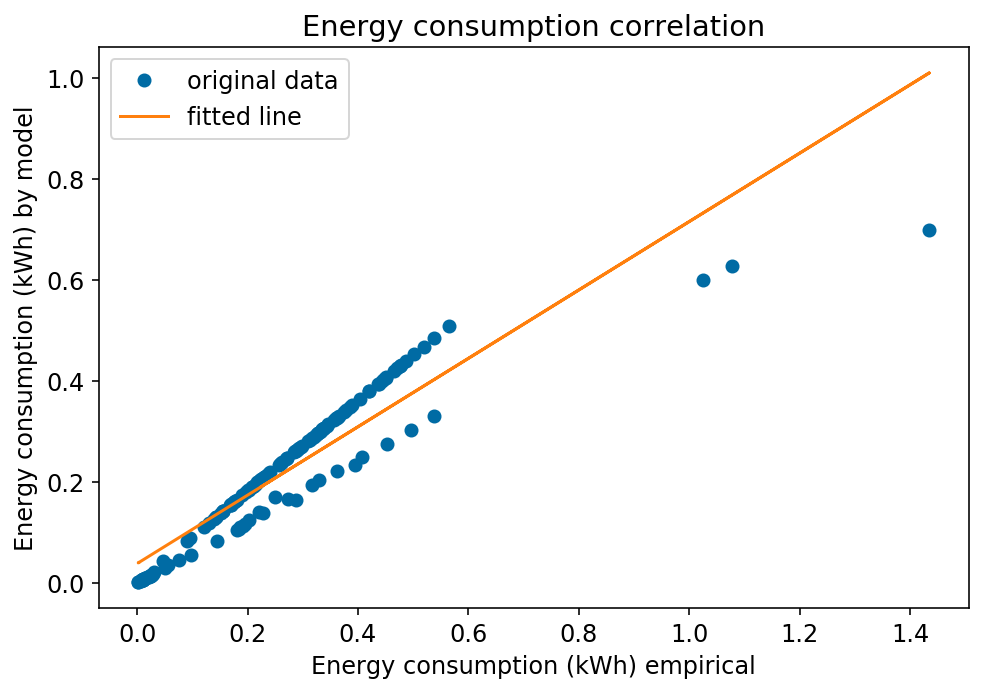

In [66]:
x = merge_df['empirical']
y = merge_df['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/model_vs_empirical.png',dpi=300)

In [67]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.09369852940374776 
 mae: 0.045812511079000376


coeff: 0.9916219081513552
r2: 0.9833140087257347


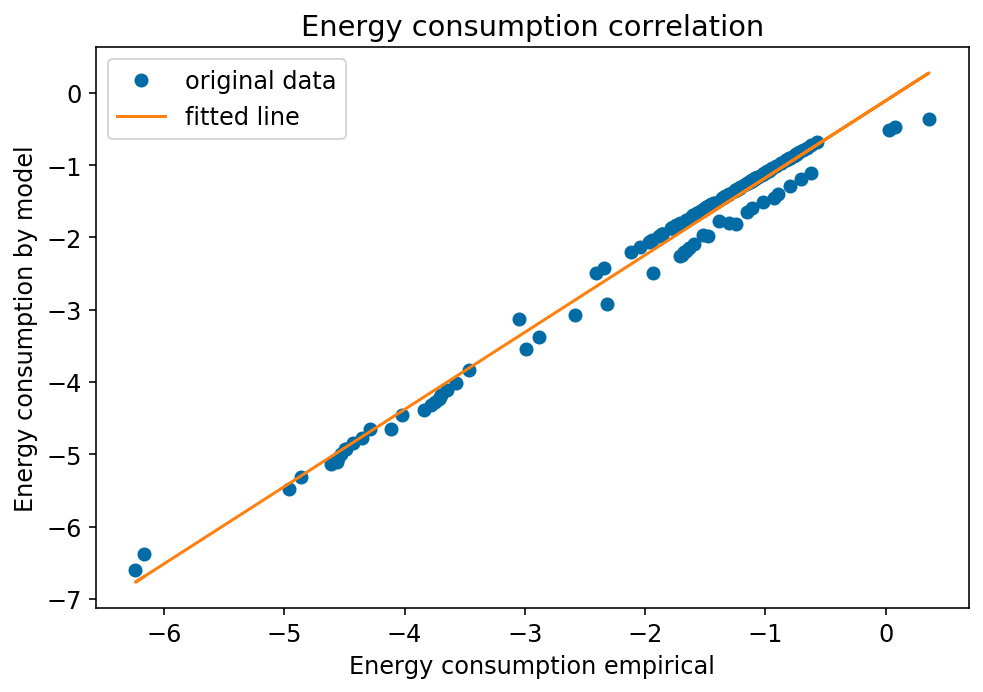

In [106]:
#log 
x = np.log(merge_df['empirical'])
y = np.log(merge_df['model_based'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption empirical")
plt.ylabel("Energy consumption by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_model_vs_empirical.png',dpi=300)

In [107]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.2998492316307128 
 mae: 0.23036953658567247
